# DL - HM02.1.2

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Define

In [2]:
MELBOURNE_DATASET = "D:/M.A/T2/Deep Learning/Assignments/HM2 - Es.Kiani - 40311614/RBF/daily-minimum-temperatures-in-melbourne.csv"
Parkinsons_DATASET = "D:/M.A/T2/Deep Learning/Assignments/HM2 - Es.Kiani - 40311614/RBF/Parkinsons.csv"

# Activation functinos

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

def softmax_derivative(x):
    s = softmax(x)
    return s * (1 - s)

def leaky_relu(x):
    return np.maximum(0, x)

def leaky_relu_derivative(x):
    return np.where(x > 0, 1, 0)

def rbf(x, center, sigma=1.0):
    return np.exp(-np.sum((x - center) ** 2) / (2 * sigma ** 2))

def rbf_derivative(x, center, sigma=1.0):
    return -rbf(x, center, sigma) * (x - center) / (sigma ** 2)

def leaky_leaky_relu(x, alpha=0.1):
    return np.where(x > 0, x, alpha * x)

def leaky_leaky_relu_derivative(x, alpha=0.1):
    return np.where(x > 0, 1, alpha)

In [4]:
def choose_function(x, name, center=None, sigma=1.0):
    if name == "sigmoid":
        return sigmoid(x)
        
    elif name == "softmax":
        return softmax(x)
        
    elif name == "relu":
        return relu(x)
    
    elif name == "rbf":
        return rbf(x, center, sigma)
        
    elif name == "leaky_relu":
        return leaky_relu(x)
        
    return x

In [5]:
def choose_derivative(x, name, center=None, sigma=1.0):
    if name == "sigmoid":
        return sigmoid_derivative(x)
        
    elif name == "softmax":
        return softmax_derivative(x)
        
    elif name == "relu":
        return relu(x)
        
    elif name == "rbf":
        return rbf_derivative(x, center, sigma)
        
    elif name == "leaky_relu":
        return leaky_relu_derivative(x)
    
    return np.ones_like(x)

# Load & normalize data

In [3]:
def load_and_normalize_parkinson(file_path):
    data = pd.read_csv(file_path)
    X = data.drop(columns=['name', 'status']).to_numpy()
    Y = data['status'].to_numpy()
    min_vals = np.min(X, axis=0)
    max_vals = np.max(X, axis=0)
    X = (X - min_vals) / (max_vals - min_vals + 1e-10)
    return X, Y

# T/T

In [4]:
def split_data(X, Y, train_ratio=0.7, val_ratio=0.1):
    num_data = X.shape[0]
    num_train = int(num_data * train_ratio)
    num_val = int(num_data * val_ratio)
    num_test = num_data - num_train - num_val
    
    indices = np.random.permutation(num_data)
    X, Y = X[indices], Y[indices]
    
    X_train, Y_train = X[:num_train], Y[:num_train]
    X_val, Y_val = X[num_train:num_train + num_val], Y[num_train:num_train + num_val]
    X_test, Y_test = X[num_train + num_val:], Y[num_train + num_val:]
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

# Hyperparameters

In [5]:
num_inputs = 22 
n1_rbf = 25   
n2 = 20    
n3 = 15   
n1_decoder = 20
n2_decoder = 25
n3_decoder = num_inputs 
n1_mlp = 15     
n2_mlp = 10      
n3_mlp = 1       
eta_rbf = 0.5
eta_auto = 0.5
eta_mlp = 0.5
epochs_auto = 500 
epochs_mlp  = 500 

# Read data

In [6]:
X, Y = load_and_normalize_parkinson(Parkinsons_DATASET)
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X, Y)

In [7]:
print("Class distribution in Y_train after SMOTE:", np.bincount(Y_train))

Class distribution in Y_train after SMOTE: [ 34 102]


In [10]:
smote = SMOTE(random_state=13)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

In [11]:
print("Class distribution in Y_train after SMOTE:", np.bincount(Y_train))

Class distribution in Y_train after SMOTE: [103 103]


# Initialization

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n1_rbf, random_state=13).fit(X_train)
centers = kmeans.cluster_centers_

# centers = X_train[np.random.choice(X_train.shape[0], n1_rbf, replace=False)]

In [13]:
w1_e = np.random.uniform(-np.sqrt(6 / (n1_rbf + num_inputs)), np.sqrt(6 / (n1_rbf + num_inputs)), (n1_rbf, num_inputs))
w2_e = np.random.uniform(-np.sqrt(6 / (n2 + n1_rbf)), np.sqrt(6 / (n2 + n1_rbf)), (n2, n1_rbf))
w3_e = np.random.uniform(-np.sqrt(6 / (n3 + n2)), np.sqrt(6 / (n3 + n2)), (n3, n2))
w1_d = np.random.uniform(-np.sqrt(6 / (n1_decoder + n3)), np.sqrt(6 / (n1_decoder + n3)), (n1_decoder, n3))
w2_d = np.random.uniform(-np.sqrt(6 / (n2_decoder + n1_decoder)), np.sqrt(6 / (n2_decoder + n1_decoder)), (n2_decoder, n1_decoder))
w3_d = np.random.uniform(-np.sqrt(6 / (n3_decoder + n2_decoder)), np.sqrt(6 / (n3_decoder + n2_decoder)), (n3_decoder, n2_decoder))
w1_mlp = np.random.uniform(-np.sqrt(6 / (n1_mlp + n3)), np.sqrt(6 / (n1_mlp + n3)), (n1_mlp, n3))
w2_mlp = np.random.uniform(-np.sqrt(6 / (n2_mlp + n1_mlp)), np.sqrt(6 / (n2_mlp + n1_mlp)), (n2_mlp, n1_mlp))
w3_mlp = np.random.uniform(-np.sqrt(6 / (n3_mlp + n2_mlp)), np.sqrt(6 / (n3_mlp + n2_mlp)), (n3_mlp, n2_mlp))

In [14]:
# w2_e = np.random.uniform(-np.sqrt(6 / (n2 + n1_rbf)), np.sqrt(6 / (n2 + n1_rbf)), (n2, n1_rbf))
# w3_e = np.random.uniform(-np.sqrt(6 / (n3 + n2)), np.sqrt(6 / (n3 + n2)), (n3, n2))
# w3_d = np.random.uniform(-np.sqrt(6 / (n2 + n3)), np.sqrt(6 / (n2 + n3)), (n2, n3))
# w2_d = np.random.uniform(-np.sqrt(6 / (num_inputs + n2)), np.sqrt(6 / (num_inputs + n2)), (num_inputs, n2))
# w1_p = np.random.uniform(-np.sqrt(6 / (n1_perceptron + n3)), np.sqrt(6 / (n1_perceptron + n3)), (n1_perceptron, n3))
# w2_p = np.random.uniform(-np.sqrt(6 / (n2_perceptron + n1_perceptron)), np.sqrt(6 / (n2_perceptron + n1_perceptron)), (n2_perceptron, n1_perceptron))

In [15]:
distances = np.linalg.norm(centers[:, np.newaxis] - centers, axis=2)
sigma_rbf = np.mean(distances[distances > 0]) / 2

# sigma_rbf = 2

# AutoEncoder training

In [16]:
for t in range(epochs_auto):
    train_loss_epoch = 0
    for i in range(X_train.shape[0]):
        X = X_train[i]
        
        # Feedforward Encoder
        o1_e = np.array([choose_function(X, "rbf", center=c, sigma=sigma_rbf) for c in centers])
        net2_e = w2_e.dot(o1_e)
        o2_e = choose_function(net2_e, "leaky_relu")
        net3_e = w3_e.dot(o2_e)
        o3_e = choose_function(net3_e, "leaky_relu")
        
        # Feedforward Decoder
        net1_d = w1_d.dot(o3_e)
        o1_d = choose_function(net1_d, "leaky_relu")
        net2_d = w2_d.dot(o1_d)
        o2_d = choose_function(net2_d, "leaky_relu")
        net3_d = w3_d.dot(o2_d)
        o3_d = choose_function(net3_d, "sigmoid")  # خروجی باید بین 0 و 1 باشد (مانند داده‌های نرمال‌شده)
        
        # محاسبه خطا و Backpropagation
        error = X - o3_d
        train_loss_epoch += np.mean(error ** 2)  # MSE Loss
        
        # Backpropagation Decoder
        delta3_d = error * choose_derivative(net3_d, "sigmoid")
        delta2_d = w3_d.T.dot(delta3_d) * choose_derivative(net2_d, "leaky_relu")
        delta1_d = w2_d.T.dot(delta2_d) * choose_derivative(net1_d, "leaky_relu")
        
        # Backpropagation Encoder
        delta3_e = w1_d.T.dot(delta1_d) * choose_derivative(net3_e, "leaky_relu")
        delta2_e = w3_e.T.dot(delta3_e) * choose_derivative(net2_e, "leaky_relu")
        delta1_e = w2_e.T.dot(delta2_e)  # برای لایه RBF از مشتق خاص خودش استفاده می‌کنیم
        
        # به‌روزرسانی وزن‌ها
        w3_d += eta_auto * np.outer(delta3_d, o2_d)
        w2_d += eta_auto * np.outer(delta2_d, o1_d)
        w1_d += eta_auto * np.outer(delta1_d, o3_e)
        w3_e += eta_auto * np.outer(delta3_e, o2_e)
        w2_e += eta_auto * np.outer(delta2_e, o1_e)
        
        # به‌روزرسانی مراکز RBF
        for j in range(n1_rbf):
            centers[j] += eta_rbf * rbf_derivative(X, centers[j], sigma_rbf) * w2_e[:, j].sum()
    
    if t % 10 == 0:
        print(f"Epoch {t}, Autoencoder Train Loss: {train_loss_epoch / X_train.shape[0]}")

Epoch 0, Autoencoder Train Loss: 0.03485408005583008
Epoch 10, Autoencoder Train Loss: 0.028566989697229317
Epoch 20, Autoencoder Train Loss: 0.028575056078833753
Epoch 30, Autoencoder Train Loss: 0.028796485139456124
Epoch 40, Autoencoder Train Loss: 0.029072929893769306
Epoch 50, Autoencoder Train Loss: 0.028829139465018645
Epoch 60, Autoencoder Train Loss: 0.03171758762389099
Epoch 70, Autoencoder Train Loss: 0.027517498237743732
Epoch 80, Autoencoder Train Loss: 0.027971782524348465
Epoch 90, Autoencoder Train Loss: 0.027866979584139487
Epoch 100, Autoencoder Train Loss: 0.02815137339668286
Epoch 110, Autoencoder Train Loss: 0.028155714803214483
Epoch 120, Autoencoder Train Loss: 0.02810274673194259
Epoch 130, Autoencoder Train Loss: 0.028046181960594514
Epoch 140, Autoencoder Train Loss: 0.028614450901926478
Epoch 150, Autoencoder Train Loss: 0.028526246668937938
Epoch 160, Autoencoder Train Loss: 0.028680491605174968
Epoch 170, Autoencoder Train Loss: 0.0319967634418817
Epoch 180

C:\Users\Stephen\AppData\Local\Temp\ipykernel_28680\100343631.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 450, Autoencoder Train Loss: 0.06195648886131156
Epoch 460, Autoencoder Train Loss: 0.07298720765154497
Epoch 470, Autoencoder Train Loss: 0.07467650307351273
Epoch 480, Autoencoder Train Loss: 0.05524859463932443
Epoch 490, Autoencoder Train Loss: 0.045176194232970604


# MLP training

In [17]:
def get_predictions(X_data, w1_e, w2_e, w3_e, w1_mlp, w2_mlp, w3_mlp, centers, sigma=1.0):
    predictions = []
    for X in X_data:
        encoder_out = compute_encoder_output(X, w1_e, w2_e, w3_e, centers, sigma)
        pred = compute_mlp_output(encoder_out, w1_mlp, w2_mlp, w3_mlp)
        predictions.append(pred)
    return np.array(predictions)

In [18]:
def compute_mlp_output(encoder_output, w1_mlp, w2_mlp, w3_mlp):
    net1_mlp = w1_mlp.dot(encoder_output)
    o1_mlp = choose_function(net1_mlp, "leaky_relu")
    net2_mlp = w2_mlp.dot(o1_mlp)
    o2_mlp = choose_function(net2_mlp, "leaky_relu")
    net3_mlp = w3_mlp.dot(o2_mlp)
    o3_mlp = choose_function(net3_mlp, "sigmoid")
    return o3_mlp

In [19]:
def compute_encoder_output(X, w1_e, w2_e, w3_e, centers, sigma=1.0):
    o1_e = np.array([choose_function(X, "rbf", center=c, sigma=sigma) for c in centers])
    net2_e = w2_e.dot(o1_e)
    o2_e = choose_function(net2_e, "leaky_relu")
    net3_e = w3_e.dot(o2_e)
    o3_e = choose_function(net3_e, "leaky_relu")
    return o3_e

In [20]:
accuracy_train = np.zeros(epochs_mlp)
accuracy_test = np.zeros(epochs_mlp)
loss_train = np.zeros(epochs_mlp)
loss_test = np.zeros(epochs_mlp)

In [21]:
for t in range(epochs_mlp):
    train_loss_epoch = 0
    for i in range(X_train.shape[0]):
        X = X_train[i]
        target = Y_train[i]
        
        o1_e = np.array([choose_function(X, "rbf", center=c, sigma=sigma_rbf) for c in centers])
        net2_e = w2_e.dot(o1_e)
        o2_e = choose_function(net2_e, "leaky_relu")
        net3_e = w3_e.dot(o2_e)
        o3_e = choose_function(net3_e, "leaky_relu")
        
        # Feedforward MLP
        net1_mlp = w1_mlp.dot(o3_e)
        o1_mlp = choose_function(net1_mlp, "leaky_relu")
        net2_mlp = w2_mlp.dot(o1_mlp)
        o2_mlp = choose_function(net2_mlp, "leaky_relu")
        net3_mlp = w3_mlp.dot(o2_mlp)
        o3_mlp = choose_function(net3_mlp, "sigmoid")
        
        error = target - o3_mlp
        train_loss_epoch += np.mean(error ** 2)
        
        # Backpropagation MLP
        delta3_mlp = error * choose_derivative(net3_mlp, "sigmoid")
        delta2_mlp = w3_mlp.T.dot(delta3_mlp) * choose_derivative(net2_mlp, "leaky_relu")
        delta1_mlp = w2_mlp.T.dot(delta2_mlp) * choose_derivative(net1_mlp, "leaky_relu")
        
        w3_mlp += eta_mlp * np.outer(delta3_mlp, o2_mlp)
        w2_mlp += eta_mlp * np.outer(delta2_mlp, o1_mlp)
        w1_mlp += eta_mlp * np.outer(delta1_mlp, o3_e)
    
    loss_train[t] = train_loss_epoch / X_train.shape[0]
    
    predictions_train = get_predictions(X_train, w1_e, w2_e, w3_e, w1_mlp, w2_mlp, w3_mlp, centers, sigma_rbf)
    predictions_test = get_predictions(X_test, w1_e, w2_e, w3_e, w1_mlp, w2_mlp, w3_mlp, centers, sigma_rbf)
    
    predictions_train_binary = (predictions_train > 0.5).astype(int)
    predictions_test_binary = (predictions_test > 0.5).astype(int)
    
    loss_test[t] = np.mean((Y_test - predictions_test) ** 2)
    accuracy_train[t] = np.mean(predictions_train_binary == Y_train)
    accuracy_test[t] = np.mean(predictions_test_binary == Y_test)
    
    if t % 10 == 0:
        print(f"Epoch {t}, Train Loss: {loss_train[t]}, Test Loss: {loss_test[t]}")
        print(f"Train Accuracy: {accuracy_train[t]}, Test Accuracy: {accuracy_test[t]}")

Epoch 0, Train Loss: 0.1554603313087055, Test Loss: 0.7278427787788214
Train Accuracy: 0.5, Test Accuracy: 0.25
Epoch 10, Train Loss: 0.21082443796598627, Test Loss: 0.2473538083209534
Train Accuracy: 0.5, Test Accuracy: 0.375
Epoch 20, Train Loss: 0.21391792383387312, Test Loss: 0.24435395536193866
Train Accuracy: 0.5, Test Accuracy: 0.375
Epoch 30, Train Loss: 0.21182607911729773, Test Loss: 0.24419534931347786
Train Accuracy: 0.5, Test Accuracy: 0.375
Epoch 40, Train Loss: 0.21007700341063554, Test Loss: 0.2498955643323523
Train Accuracy: 0.5, Test Accuracy: 0.525
Epoch 50, Train Loss: 0.21446045793960725, Test Loss: 0.2498614166574797
Train Accuracy: 0.5, Test Accuracy: 0.525
Epoch 60, Train Loss: 0.21434152832266448, Test Loss: 0.24988737376651243
Train Accuracy: 0.5, Test Accuracy: 0.525
Epoch 70, Train Loss: 0.21421598432572278, Test Loss: 0.24990499733268096
Train Accuracy: 0.5, Test Accuracy: 0.525
Epoch 80, Train Loss: 0.2141027944313918, Test Loss: 0.24991632269962555
Train 

# Result

Accuracy Train: 0.5
Accuracy Test: 0.5


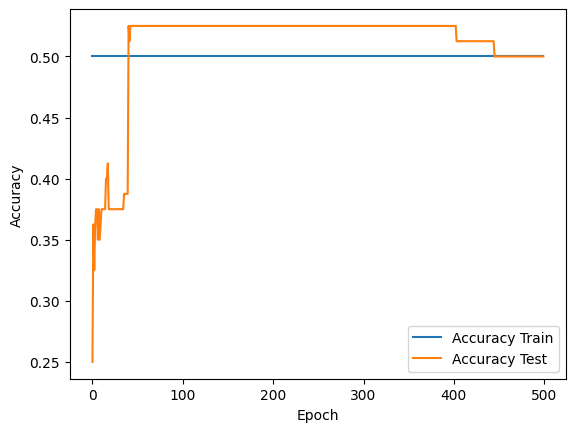

In [22]:
print("Accuracy Train:", accuracy_train[-1])
print("Accuracy Test:", accuracy_test[-1])
plt.plot(accuracy_train, label="Accuracy Train")
plt.plot(accuracy_test, label="Accuracy Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
cm_train = confusion_matrix(Y_train, predictions_train_binary)
cm_test = confusion_matrix(Y_test, predictions_test_binary)

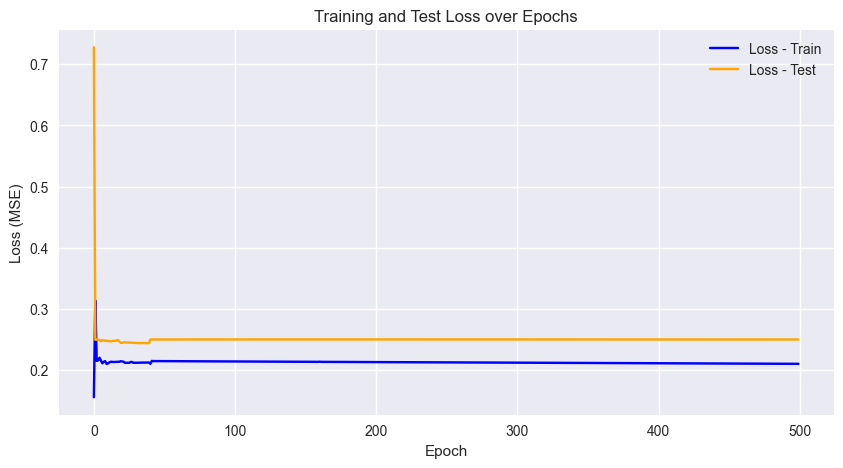

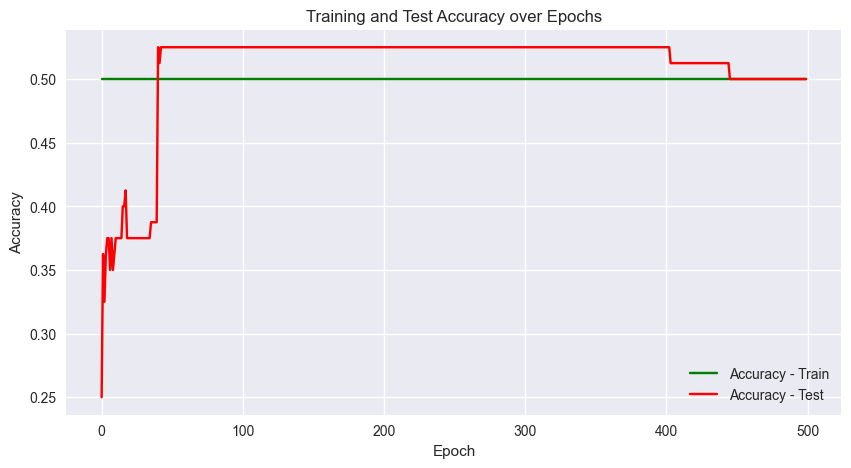

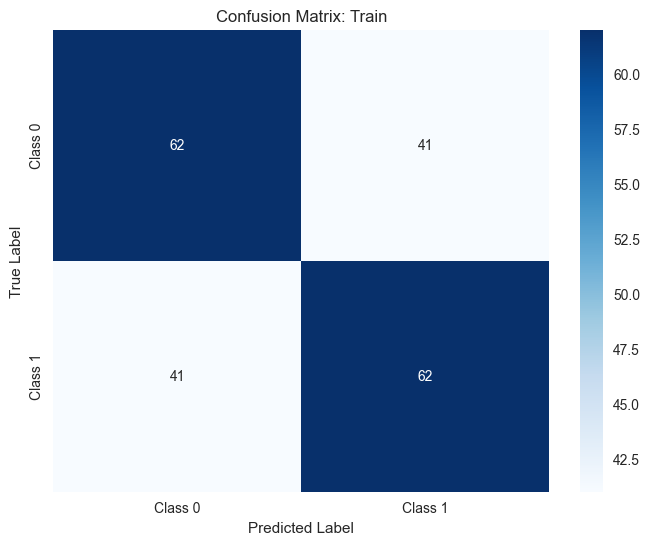

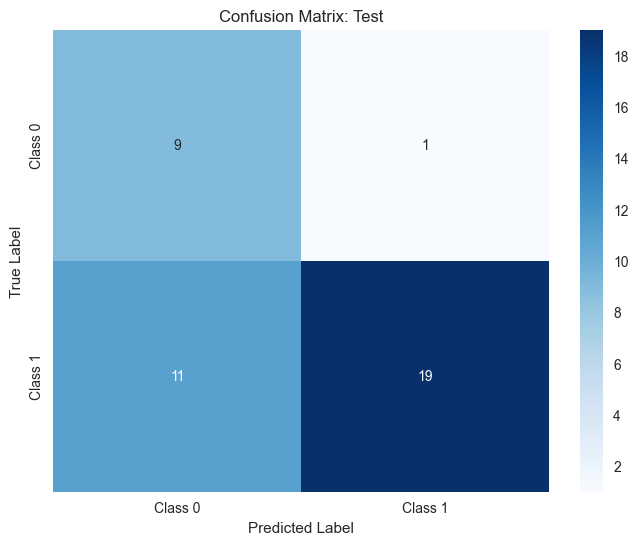

In [24]:
# نمایش نتایج
plt.style.use('seaborn-v0_8')

plt.figure(figsize=(10, 5))
plt.plot(loss_train, label="Loss - Train", color="blue")
plt.plot(loss_test, label="Loss - Test", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Test Loss over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(accuracy_train, label="Accuracy - Train", color="green")
plt.plot(accuracy_test, label="Accuracy - Test", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Train")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=["Class 0", "Class 1"],
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix: Test")
plt.show()

### Some tests

In [25]:
# print("Delta2_p:", delta2_p)
# print("Delta1_p:", delta1_p)

In [26]:
print("X after normalization:", X.min(), X.max())

X after normalization: 0.00857976856720088 0.9525765140384062


In [27]:
print("Class distribution in Y_train:", np.bincount(Y_train))
print("Class distribution in Y_test:", np.bincount(Y_test))

Class distribution in Y_train: [103 103]
Class distribution in Y_test: [10 30]


In [28]:
print("Predictions distribution (train):", np.histogram(predictions_train, bins=10))
print("Predictions distribution (test):", np.histogram(predictions_test, bins=10))

Predictions distribution (train): (array([172,   3,   4,   3,   4,   7,   3,   3,   6,   1], dtype=int64), array([0.5       , 0.5002224 , 0.5004448 , 0.50066721, 0.50088961,
       0.50111201, 0.50133441, 0.50155682, 0.50177922, 0.50200162,
       0.50222402]))
Predictions distribution (test): (array([28,  2,  1,  2,  1,  0,  2,  2,  1,  1], dtype=int64), array([0.5       , 0.50019262, 0.50038524, 0.50057787, 0.50077049,
       0.50096311, 0.50115573, 0.50134835, 0.50154097, 0.5017336 ,
       0.50192622]))


In [29]:
# predictions_train = get_predictions(X_train, w2_e, w3_e, w1_p, w2_p, centers, sigma_rbf)
# predictions_test = get_predictions(X_test, w2_e, w3_e, w1_p, w2_p, centers, sigma_rbf)

# print("Predictions distribution (train):", np.histogram(predictions_train, bins=10))
# print("Predictions distribution (test):", np.histogram(predictions_test, bins=10))